In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List

In [10]:
pillbox = np.load('pillbox.npy')
test = np.load('test_slic.npy')
test_line = np.load('test_line_slic.npy')

In [ ]:
def detect_epsu(img):
    
    OUTPUT = img.copy()
    GRAY = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 20,
                                param1 = 100, param2 = 22,
                                minRadius = 20, maxRadius = 26)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            cv2.circle(OUTPUT, center, 1, (0, 100, 100), 3)
            radius = i[2]
            cv2.circle(OUTPUT, center, radius, (255, 0, 0), 3)

    plt.imshow(OUTPUT)



def detect_biox(img):
    
    OUTPUT = img.copy()
    GRAY = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 20,
                                param1 = 100, param2 = 22,
                                minRadius = 28, maxRadius = 36)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            cv2.circle(OUTPUT, center, 1, (0, 100, 100), 3)
            radius = i[2]
            cv2.circle(OUTPUT, center, radius, (255, 0, 0), 3)

    plt.imshow(OUTPUT)

In [215]:
def detect_keto(img):
    
    OUTPUT = img.copy()
    GRAY = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 80,
                                param1 = 2, param2 = 24,
                                minRadius = 43, maxRadius = 50)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            cv2.circle(OUTPUT, center, 1, (0, 100, 100), 3)
            radius = i[2]
            cv2.circle(OUTPUT, center, radius, (255, 0, 0), 3)

    plt.imshow(OUTPUT)

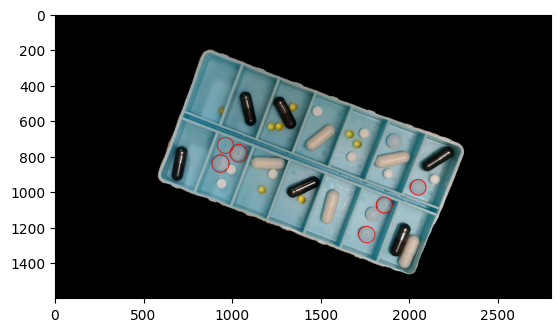

In [216]:
detect_keto(test)

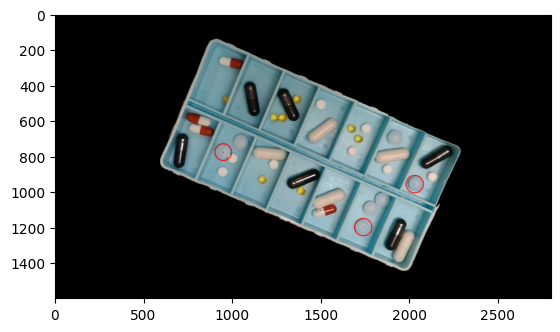

In [217]:
detect_keto(test_line)

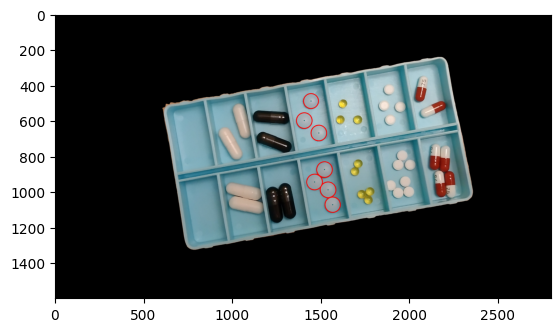

In [113]:
detect_keto(pillbox)